In [34]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import cv2, imageio

import os, itertools, pickle
from pprint import pprint

from util import *
from putil import *
from config import *
%load_ext autoreload
%aimport util
%aimport putil
%aimport config
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
series = ['pool_room', 'staircase', 'lounge', 'courtyard', 'cory_front', 'cory_breezeway', 'soda_front']

for serie in series:
    processes = []
    s_dir = Data + serie + '/'
    print('generating', serie)
    for c in range(1, Num_cameras + 1):
        camera_matrix, distortion_coef, new_camera_matrix = cameras[c]
        input_file = get_data_path(serie, c)
        name = get_name(input_file)
        output_file = s_dir + 'calibrated/' + name + '.mp4'
        make_dir(s_dir + 'calibrated/')
        if os.path.exists(output_file):
            continue
        cmd = 'python %sundistort.py %s %s %s' % (Scripts, input_file, Calibrations + str(c) + '/', output_file)
        processes.append(shell(cmd, wait=False))
    for process in processes:
        out, err = process.communicate()
        print(out)
        print(err)
    print('finished', serie)
    print()

In [43]:
from PIL import Image
import piexif, json

cameras = { c : load_calibration(c) for c in Cam_ids }

serie = 'cory_breezeway'
seconds = 10
used_cams = Cam_ids

cams_string = '1-6' if used_cams == Cam_ids else ','.join(map(str, used_cams))
serie_dir = make_dir(Reconstructions + serie + '/')
print('generating files for', serie)
uncalibrated_dir = Data + serie + '/'

camera_models = {}
for c in used_cams:
    rec_dir = make_dir(serie_dir + '%s_3fps_%ss/' % (cams_string, seconds))
    image_dir = make_dir(rec_dir + 'images/')
    v_path = get_data_path(uncalibrated_dir, c, name_is_dir=True)
    v_name = get_name(v_path, ext=False)
    video = read_video(v_path)
    camera_matrix, distortion_coef, new_camera_matrix = cameras[c]
    undistorted_video = (cv2.undistort(frame, camera_matrix, distortion_coef, None, new_camera_matrix) for frame in video)

    focal_length = np.mean(np.diag(new_camera_matrix)[:2])
    focal_ratio = focal_length / np.max(Video_hw)
    camera_models['v2 gopro4 camera%s 2704 2028 perspective 0' % c] = {
        'focal_prior' : focal_ratio, 'focal' : focal_ratio,
        'width' : V_w, 'height' : V_h,
        'k1': 0.0, 'k1_prior': 0.0, 
        'k2': 0.0, 'k2_prior': 0.0, 
        'projection_type': 'perspective', 
    }
    for i, frame in enumerate(undistorted_video):
        if i == seconds * 30: break
        if i % 10 == 0:
            image_name = image_dir + v_name + '_%04d.jpg' % i
            img = Image.fromarray(frame)
            exif_dict = {
                'Exif' : {
                    piexif.ExifIFD.LensMake : 'gopro4',
                    piexif.ExifIFD.LensModel : 'camera%s' % c
                }
            }
            exif_bytes = piexif.dump(exif_dict)
            img.save(image_name, "jpeg", exif=exif_bytes)
    video.close()
override_file = rec_dir + 'camera_models_overrides.json'
save_json(camera_models, override_file)
shutil.copy(Root + 'OpenSfM/config.yaml', rec_dir + 'config.yaml')
#         video_to_frames(v_path, image_dir, nth=10, start=0, duration=20)

generating files for cory_breezeway


In [ ]:
import time
t = time.time()

video = cv2.VideoCapture(get_data_path('pool_room', 1))
success, image = video.read()
num_fail = 0
v_frames = []
while num_fail < 3:
    if success:
        num_fail = 0
        v_frames.append(image)
    else:
        num_fail += 1
    success, image = video.read()

print(time.time() - t)

In [2]:
serie = 'cory_breezeway'
calibrated_dir = Data + serie + '/calibrated/'
c1 = 1
c2 = 5
v_p_1 = get_data_path(calibrated_dir, c1, name_is_dir=True)
v_p_2 = get_data_path(calibrated_dir, c2, name_is_dir=True)
v1 = read_video(v_p_1)
v2 = read_video(v_p_2)

In [3]:
it = itertools.izip(v1, v2)

In [4]:
def next_k(it, k):
    return [next(it) for _ in range(k)][-1]
f1, f2 = next_k(it, 20)
def show_img(img, figsize=(12, 9)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
# show_img(f1)
# show_img(f2)

In [390]:
mask1 = np.zeros_like(f1[:, :, 0])
mask1[1200:, 300:] = 1
# show_img((f1 * 0.5 + np.expand_dims(mask1, 2) * 127).astype(np.uint8))
mask2 = np.zeros_like(f2[:, :, 0])
mask2[:, 2000:] = 1
# show_img((f2 * 0.5 + np.expand_dims(mask2, 2) * 127).astype(np.uint8))

In [6]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(f1, mask1)
kp2, des2 = sift.detectAndCompute(f2, mask2)

In [7]:
out = np.zeros_like(f1)
# show_img(cv2.drawKeypoints(f1, kp1, out, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
# show_img(cv2.drawKeypoints(f2, kp2, out, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

In [8]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)
good = [m for m, n in matches if m.distance < 0.6 * n.distance]

In [366]:
from skimage.draw import polygon

draw_f1 = f1.copy()
if len(good) > 10:
    g_kp1, g_kp2 = zip(*[(kp1[m.queryIdx], kp2[m.trainIdx]) for m in good])
    pts1 = np.float32(map(lambda x: x.pt, g_kp1)).reshape(-1, 1, 2)
    pts2 = np.float32(map(lambda x: x.pt, g_kp2)).reshape(-1, 1, 2)

    thres = 1
    H, mask = cv2.findHomography(pts1, pts2, method=cv2.RANSAC, ransacReprojThreshold=thres)
    H_inv, mask_inv = cv2.findHomography(pts2, pts1, method=cv2.RANSAC, ransacReprojThreshold=thres)
    mask = (mask * mask_inv).ravel().tolist()
    
    # (4 corners, 1, 2 dimensions x and y)
    img_corners = np.float32([[
        [0, 0],
        [0, Video_height - 1],
        [Video_width - 1, Video_height - 1],
        [Video_width - 1, 0]
    ]]).reshape(4, 1, 2)
    img_corners = np.float32([[
        [300, 1200],
        [300, Video_height - 1],
        [Video_width - 1, Video_height - 1],
        [Video_width - 1, 1200]
    ]]).reshape(4, 1, 2)
    cor_t = cv2.perspectiveTransform(img_corners, H) # (4 corners, 1, 2 dimensions x and y) 
    cv2.polylines(draw_f1, [img_corners.astype(int)], True, 255, 3, cv2.LINE_AA)
    cor_t = np.rint(cor_t).astype(int)
    min_x, min_y = np.minimum(np.min(cor_t[:, 0], axis=0), 0) - 500
    max_x, max_y = np.maximum(np.max(cor_t[:, 0]) + 1, Video_wh) + 500
    new_h = max_y - min_y
    new_w = max_x - min_x

#     output = cv2.warpPerspective(f1, H, (new_w, new_h))
#     output[:Video_height, :Video_width] = f2
#     show_img(output)
    
    draw2 = np.zeros((new_h, new_w, 3), dtype=np.uint8)
    draw2[-min_y : Video_height - min_y, -min_x : Video_width - min_x] = f2
    
    yy_t, xx_t = polygon(cor_t[:, 0, 1], cor_t[:, 0, 0])
    k = len(yy_t)
    coords_t = np.array([xx_t, yy_t, np.ones((k,))]) # ((x, y, 1), k)
    
    coords = np.dot(H_inv, coords_t) # ((x't, y't, t), k)
    coords = np.rint(coords[:2] / coords[2]).astype(int) # ((x', y'), k)
    inbound = np.all(coords < Video_wh.reshape(2, 1), axis=0)
    coords = coords[:, inbound]
    xx, yy = coords
    xx_t, yy_t = xx_t[inbound], yy_t[inbound]
    
    draw2[yy_t - min_y, xx_t - min_x] = f1[yy, xx]
#     cv2.polylines(draw2, [cor_t - np.array([[[min_x, min_y]]])], True, 255, 40, cv2.LINE_8)
    
#     show_img(draw_f1)
#     show_img(draw2, figsize=(15, 40))
#     side_by_side = cv2.drawMatches(
#         np.array(f1), kp1,
#         np.array(f2), kp2,
#         good,
#         None,
#         matchesMask=mask,
#         matchColor=(0, 255, 0),
#         singlePointColor=(255, 0, 0),
#         flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT
#     )
#     show_img(side_by_side)

In [143]:
num, rots, trans, norms = cv2.decomposeHomographyMat(H, camera_matrix)

[array([[  9.65151428e-01],
        [  3.82032088e-04],
        [ -2.61691756e-01]]), array([[ -9.65151428e-01],
        [ -3.82032088e-04],
        [  2.61691756e-01]]), array([[  9.65151520e-01],
        [ -4.20875050e-04],
        [ -2.61691358e-01]]), array([[ -9.65151520e-01],
        [  4.20875050e-04],
        [  2.61691358e-01]])]

In [367]:
camera_matrix = np.load(Calibrations + '1/camera_matrix.npy')
camera_matrix = np.eye(3)
focal = 1200
camera_matrix[0][0] = camera_matrix[1][1] = focal
p_point = tuple(Video_wh / 2)

camera_matrix[:2, 2] = p_point
print(camera_matrix)
cam_i = np.linalg.inv(camera_matrix)
print(cam_i)

[[  1.20000000e+03   0.00000000e+00   1.35200000e+03]
 [  0.00000000e+00   1.20000000e+03   1.01400000e+03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[  8.33333333e-04   0.00000000e+00  -1.12666667e+00]
 [  0.00000000e+00   8.33333333e-04  -8.45000000e-01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [368]:
mask_ar = np.array(mask)
pts1_filt = pts1[mask_ar == 1]
pts2_filt = pts2[mask_ar == 1]
E_12, mask2 = cv2.findEssentialMat(pts1_filt, pts2_filt, focal, p_point, method=cv2.RANSAC, prob=0.999, threshold=0.1)

In [369]:
def to_homo(x):
    for axis, size in enumerate(x.shape):
        if size == 2:
            break
    else:
        raise RuntimeError()
    ones_shape = list(x.shape)
    ones_shape[axis] = 1
    return np.concatenate((x, np.ones(ones_shape)), axis=axis)

def mult_homo(M, x):
    n, d = x.shape
    if d == 2:
        x = to_homo(x)
    output = np.dot(x, M.T)
    return output[:, :2] / output[:, 2:3]

In [385]:
_, R, t, mask3 = cv2.recoverPose(E_12, pts1_filt, pts2_filt, focal=focal, pp=p_point, mask=mask2)

[[-0.3813381 ]
 [ 0.05207842]
 [-0.11452343]]


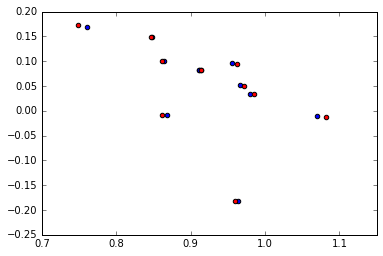

In [386]:
pts1_norm = mult_homo(cam_i, pts1_filt[:, 0, :])
pts2_norm = mult_homo(cam_i, pts2_filt[:, 0, :])

mask3 = mask3.ravel()
pts1_homo = to_homo(pts1_norm)[mask3 == 1]
pts2_homo = to_homo(pts2_norm)[mask3 == 1]

pts1_r = np.dot(R, pts1_homo.T)
A = np.concatenate((t[0] - pts2_homo[:, 0] * t[2], t[1] - pts2_homo[:, 1] * t[2]), axis=0)
b = np.concatenate((pts2_homo[:, 0] * pts1_r[2] - pts1_r[0], pts2_homo[:, 1] * pts1_r[2] - pts1_r[1]), axis=0)
s = np.dot(A, b) / np.dot(A, A)

t_scaled = t * s

pts2_pred = pts1_r + t_scaled
pts2_pred /= pts2_pred[2:]
pts2_pred = pts2_pred.T
plt.scatter(*zip(*pts2_homo[:, :2]))
plt.scatter(*zip(*pts2_pred[:, :2]), c='red')
plt.show()

In [336]:
serie = 'cory_breezeway'
calibrated_dir = Data + serie + '/calibrated/'
vids = []
frames = []
for i in range(1, Num_cameras + 1):
    v_p = get_data_path(calibrated_dir, i, name_is_dir=True)
    v = iter(read_video(v_p))
    vids.append(v)
    frames.append(next_k(v, 20))

In [ ]:
camera_matrix = np.load(Calibrations + '1/camera_matrix.npy')
camera_matrix = np.eye(3)
focal = 1200
camera_matrix[0][0] = camera_matrix[1][1] = focal
p_point = tuple(Video_wh / 2)

camera_matrix[:2, 2] = p_point
print(camera_matrix)
cam_i = np.linalg.inv(camera_matrix)
print(cam_i)

In [412]:
from skimage.draw import polygon

def calculate_R_t(f1, f2, mask1, mask2):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(f1, mask1)
    kp2, des2 = sift.detectAndCompute(f2, mask2)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    good = [m for m, n in matches if m.distance < 0.6 * n.distance]
    
    if len(good) > 10:
        g_kp1, g_kp2 = zip(*[(kp1[m.queryIdx], kp2[m.trainIdx]) for m in good])
        pts1 = np.float32(map(lambda x: x.pt, g_kp1))
        pts2 = np.float32(map(lambda x: x.pt, g_kp2))
        
        H, mask = cv2.findHomography(pts1, pts2, method=cv2.RANSAC, ransacReprojThreshold=1)
        mask = mask[:, 0] == 1
        pts1 = pts1[mask]
        pts2 = pts2[mask]

        # p2 * E * p1 = 0
        E, mask = cv2.findEssentialMat(pts1, pts2, focal, p_point, method=cv2.RANSAC, prob=0.999, threshold=0.1)
        # R * p1 + t = p2
        _, R, t, mask = cv2.recoverPose(E, pts1, pts2, focal=focal, pp=p_point, mask=mask)
        mask = mask[:, 0] == 1
        
        pts1 = pts1[mask]
        pts2 = pts2[mask]
        pts1_norm = mult_homo(cam_i, pts1)
        pts2_norm = mult_homo(cam_i, pts2)
        pts1_homo = to_homo(pts1_norm)
        pts2_homo = to_homo(pts2_norm)

        pts1_r = np.dot(R, pts1_homo.T)
        A = np.concatenate((t[0] - pts2_homo[:, 0] * t[2], t[1] - pts2_homo[:, 1] * t[2]), axis=0)
        b = np.concatenate((pts2_homo[:, 0] * pts1_r[2] - pts1_r[0], pts2_homo[:, 1] * pts1_r[2] - pts1_r[1]), axis=0)
        s = np.dot(A, b) / np.dot(A, A)

        t_scaled = t * s

        return R, t_scaled[:, 0]
    return None

In [421]:
f1 = frames[0]
f2 = frames[4]
mask1 = np.zeros_like(f1[:, :, 0])
mask1[1200:, 300:] = 1
mask2 = np.zeros_like(f2[:, :, 0])
mask2[:, 2000:] = 1
calculate_R_t(f1, f2, mask1, mask2)

(array([[  1.06690404e-01,  -1.75333521e-01,   9.78711047e-01],
        [  9.94129221e-01,   9.84215235e-04,  -1.08194837e-01],
        [  1.80069194e-02,   9.84508602e-01,   1.74409183e-01]]),
 array([-0.36131619,  0.08678943, -0.11385682]))

In [422]:
f1 = frames[0]
f2 = frames[1]
mask1 = np.zeros_like(f1[:, :, 0])
mask1[:, 1900:] = 1
mask2 = np.zeros_like(f2[:, :, 0])
mask2[:400, 200:] = 1
calculate_R_t(f1, f2, mask1, mask2)

(array([[ -3.28732626e-02,  -9.95479766e-01,   8.91032233e-02],
        [  3.41054408e-01,  -9.49732050e-02,  -9.35233650e-01],
        [  9.39468594e-01,  -3.55134312e-04,   3.42634842e-01]]),
 array([-0.00517038, -0.0321515 ,  0.05537801]))

In [426]:
f1 = frames[0]
f2 = frames[2]
mask1 = np.zeros_like(f1[:, :, 0])
mask1[:, 500:] = 1
mask2 = np.zeros_like(f2[:, :, 0])
mask2[1600:, 300:] = 1
calculate_R_t(f1, f2, mask1, mask2)

(array([[ 0.02203965, -0.99975585, -0.00157782],
        [ 0.37695957,  0.00684834,  0.92620439],
        [-0.92596746, -0.021008  ,  0.37701847]]),
 array([-0.0164208 ,  0.19847237,  0.17552101]))

In [ ]:
f1 = frames[0]
f2 = frames[3]
mask1 = np.zeros_like(f1[:, :, 0])
mask1[:, 500:] = 1
mask2 = np.zeros_like(f2[:, :, 0])
mask2[1600:, 300:] = 1
calculate_R_t(f1, f2, mask1, mask2)

In [427]:
Rts = [
    (
        np.eye(3),
        np.zeros(3)
    ),
    (np.array([[ -3.28732626e-02,  -9.95479766e-01,   8.91032233e-02],
        [  3.41054408e-01,  -9.49732050e-02,  -9.35233650e-01],
        [  9.39468594e-01,  -3.55134312e-04,   3.42634842e-01]]),
 np.array([-0.00517038, -0.0321515 ,  0.05537801])),
    (np.array([[ 0.02203965, -0.99975585, -0.00157782],
        [ 0.37695957,  0.00684834,  0.92620439],
        [-0.92596746, -0.021008  ,  0.37701847]]),
 np.array([-0.0164208 ,  0.19847237,  0.17552101])),
    (
        None,
        None
    ),
    (
        np.array([
            [  1.06690404e-01,  -1.75333521e-01,   9.78711047e-01],
            [  9.94129221e-01,   9.84215235e-04,  -1.08194837e-01],
            [  1.80069194e-02,   9.84508602e-01,   1.74409183e-01]
        ]),
        np.array([-0.36131619,  0.08678943, -0.11385682])
    ),
    (
        np.array([
            [1, 0, 0],
            [0, -1, 0],
            [0, 0, -1]
        ]),
        None
    )
]

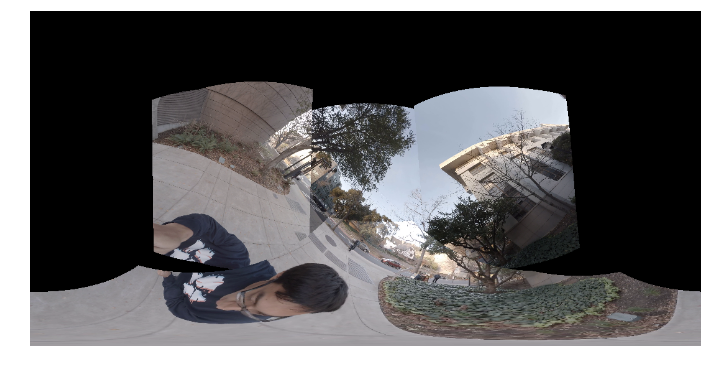

In [428]:
scale = 3
p_w, p_h = 360 * scale, 180 * scale
px_to_rad = lambda x: x / scale * np.pi / 180
p = np.zeros((p_h, p_w, 3), dtype=np.uint8)
shift_x, shift_y = Video_wh / 2
in_range = lambda x, min_x, max_x: min_x <= x < max_x
is_inbound = lambda x, y: (0 <= x < Video_width) and (0 <= y < Video_height)
for i in range(p_w):
    theta = px_to_rad(i - p_w // 2) 
    for j in range(p_h):
        phi = px_to_rad(j - p_h // 2)
        vec = np.array([np.sin(theta) * np.cos(phi), np.sin(phi), np.cos(theta) * np.cos(phi)])
        
        for f, (R, t) in zip(frames, Rts):
            if R is None or t is None:
                continue
            x_t, y_t, z_t = np.dot(R, vec) + np.abs(vec[2]) * t
            if z_t > 0:
                x_f = int(round(x_t / z_t * focal + shift_x))
                y_f = int(round(y_t / z_t * focal + shift_y))
                if is_inbound(x_f, y_f):
                    p[j, i] = f[y_f, x_f]
                    continue
show_img(p)

In [46]:
input = src_pts
true = dst_pts
res = np.append(input.reshape((76, 2)).T, np.ones((1, 76)), axis=0)
pred = np.dot(H, res)
pred = pred[:2] / pred[2]
residuals = np.linalg.norm(true.reshape(76, 2) - pred.T, axis=1)
residuals = residuals[residuals < 20]
print(len(residuals))
print(np.mean(residuals))
plt.hist(residuals)
plt.show()

NameError: name 'src_pts' is not defined

In [31]:
H_inv, mask_inv = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 0.3)

In [ ]:
def warpImage(img, H, data1, data2):
    h,w,t = img.shape
    temp = np.dot(H, np.array([[0,0,1],[w-1,0,1],[w-1,h-1,1],[0,h-1,1]]).T)
    temp = temp[0:2,:]/temp[2,:]
    rr, cc = polygon(temp[0],temp[1])
    temp = np.ones((3,rr.shape[0]))
    temp[0] = np.rint(rr).astype(int)
    temp[1] = np.rint(cc).astype(int)
    h,w,t = img.shape
    H_inv = computeH(data2, data1)
    nimg = np.zeros((h,w,3))
    n_coords = np.dot(H_inv, temp)
    n_coords = np.rint(n_coords[0:2,:]/n_coords[2,:]).astype(int)
    new_img = np.zeros((np.max(cc)+1,np.max(rr)+1,3))
    new_img[cc,rr]=img[n_coords[1],n_coords[0]]
    return new_img

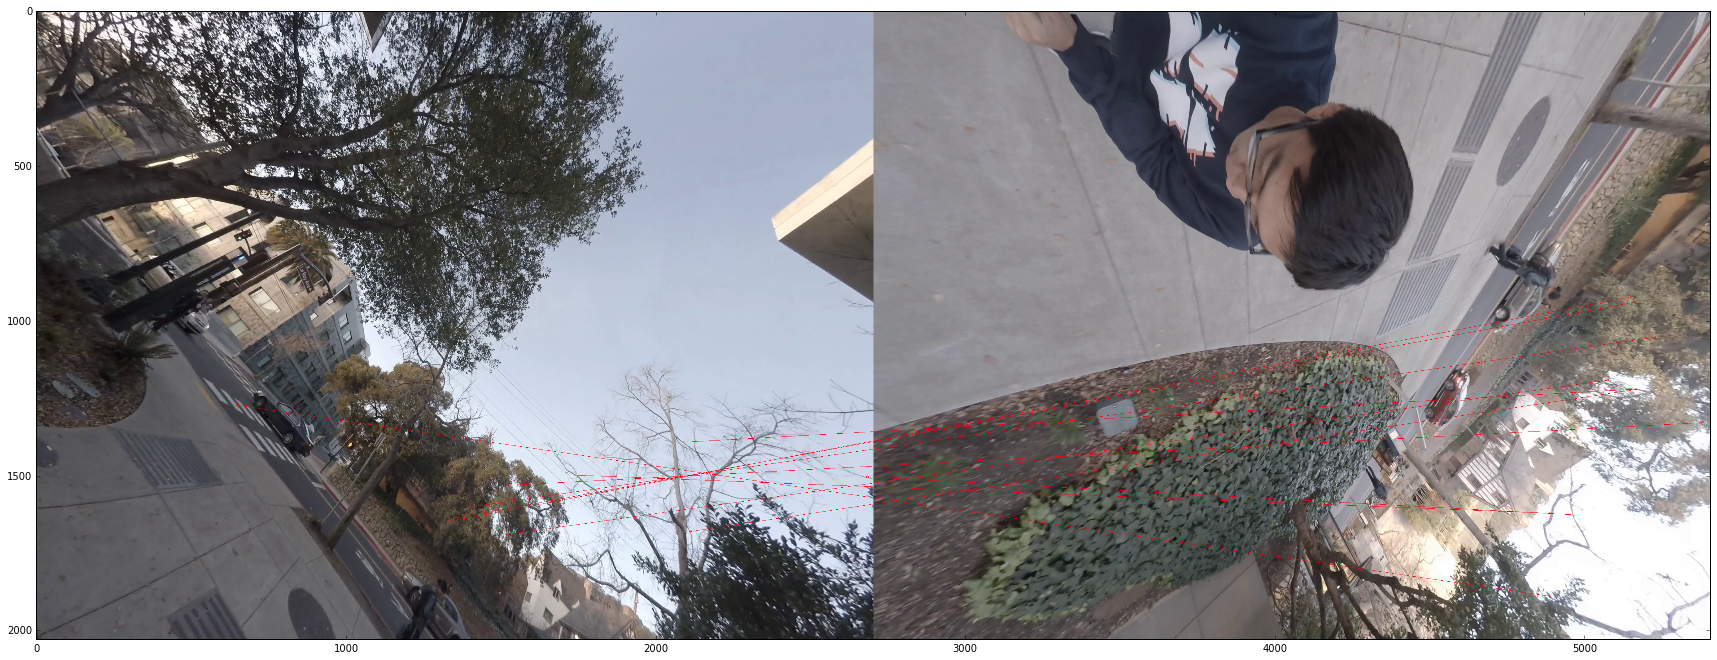

In [30]:
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=None,
                   matchesMask=matches_mask,
                   flags=2)

def drawMatches(img1, kp1, img2, kp2, matches):
    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    # Create the output image
    # The rows of the output are the largest between the two images
    # and the columns are simply the sum of the two together
    # The intent is to make this a colour image, so make this 3 channels
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = img1

    # Place the next image to the right of it
    out[:rows2,cols1:] = img2

    for mat in matches[:10]:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255,0,0), 1)

    return out

img_match = drawMatches(f1, kp1, f2, kp2, good)

plt.figure(figsize=(30, 15))
plt.imshow(img_match)
plt.show()